In [1]:
import lib
import os
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

# Введение
Основным материалом является документ. Этот документ атомарно состоит из строк. 
Первым делом необходимо выделить из изоброжения картинки строк, чтоб потом можно было с ними что-то делать. 
Предполагается, что программа в которой будет проводится классификация может давать строки.
В случае этого проекта эту роль имитирует функция get_row_image(path_img)


Доступные файлы для работы, это файлы к которым есть .npy файл, так как программа опирается на него


In [2]:
for name_file in os.listdir(lib.PATH_IMG):
    if name_file[-4:] == ".npy":
        print(name_file[:-4])

border.png
border2.png
img_10.jpeg
text_1.png
text_11.png
text_12.jpeg
text_13.png
text_17.png
text_19.png
text_2.png
text_20.png
text_21.png
text_4.png
text_5.png
text_6.png
text_7.png
text_8.png
text_9.png


In [56]:
name_file = "text_17.png"
path_img = os.path.join(lib.PATH_IMG,name_file)
data = lib.get_row_image(path_img)


img_doc = data["img"]
npy_mtrx_doc = data["npy"]
rows = data["image_rows"]
lib.draw_img(img_doc, [], [])

В результате имеем само изображение, матрицу ручной разметки и собственно список строк документа
с которомы дальше нужно работать

# Идеи
Далее будут представленны методы и идеи как работать со строками. Вся работа будет вестись со списком rows

### Поиск уникальной строки
Строки могут быть трех видов:
1. Обычный текст
2. Жирный текст
3. Смешенный текст

При этом эти две категории можно поделить на две:
1. Однородный текст
2. Неоднородный текст

Предполагается, что задача классификации на две категории куда проще, чем на 3

In [57]:
def delta_coef(rows):
    info_row = []
    type_row = []

    for j in range(len(rows)):
        row_gray = cv2.cvtColor(rows[j], cv2.COLOR_BGR2GRAY)
        words_row = pytesseract.image_to_data(row_gray, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
        array_coef = []
        N = len(words_row["word_num"])
        for i in range(N):
            if words_row["level"][i] == 5:
                x0, y0, w0, h0 = words_row["left"][i], words_row["top"][i], words_row["width"][i], words_row["height"][i]
                word_img = row_gray[y0:y0+h0, x0:x0+w0]
                word_img = (255-word_img)/255
                coef = word_img.mean()

                if w0 > h0*3: # Слова из 1-3 символов являются проблемой
                    array_coef.append(coef)

        if len(array_coef) == 0:
            k = 0
        else:
            min_word = np.min(array_coef)
            max_word = np.max(array_coef)
            k = max_word-min_word
        print("\r"+f"{j/len(rows):2.2f} % ", end="")

        info_row.append(k)
        type_row.append(2 if k > 40 else 0)
    print("\r 100.00 %")
    return info_row, type_row


In [58]:
# ВЫВОД
# info_row, type_row = delta_coef(rows)
# lib.draw_img(img_doc, npy_mtrx_doc, type_row, info_row)

### Корреляция
Ключевыми значениями для слов являются:
- среднее значения интенсивности
- пороговое кол-во символов (например 0-10, 10-20, 20-30, ...)
- минимальное и максимальное значения

попробуем построить графические зависимости с целью выявить закономерность

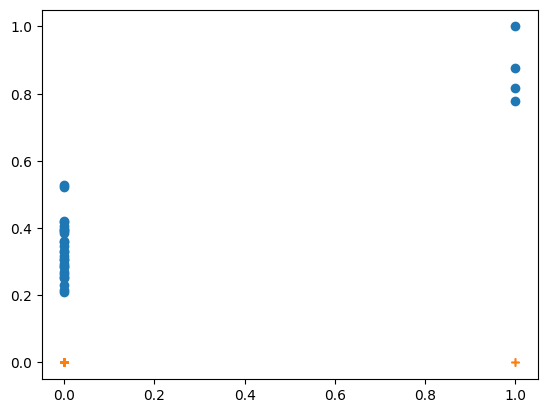

In [59]:
def mean_row(row):
    return row.mean()

def row_level_0_10(row):
    h, w, _ = row.shape
    row = row[row < 10]
    return len(row)/(h*w)

def row_level_10_20(row):
    h, w, _ = row.shape
    row = row[row < 20]
    row = row[row > 10]
    return len(row)/(h*w)

def row_level_20_30(row):
    h, w, _ = row.shape
    row = row[row < 30]
    row = row[row > 20]
    return len(row)/(h*w)

def get_coef_fun(rows, fun):
    array_coef = []
    for row in rows:
        coef = fun(row)
        array_coef.append(coef)
    array_coef = np.array(array_coef)
    if array_coef.max() == 0:
        return array_coef
    else:
        return array_coef/array_coef.max()

def std_word_level_0_10(row):
    gray_row = cv2.cvtColor(row, cv2.COLOR_BGR2GRAY)
    words_row = pytesseract.image_to_boxes(gray_row, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
    array_coef = []
    N = len(words_row["char"])
    for i in range(N):
        
        x0, y0, x1, y1 = words_row["left"][i], words_row["top"][i], words_row["right"][i], words_row["bottom"][i]
        word_img = row_gray[y1:y0, x0:x1]
        word_img = word_img[word_img < 30]
        array_coef.append(len(word_img))
    array_coef = np.array(array_coef)
    return array_coef.mean()
            
y1 = get_coef_fun(rows, mean_row)
y2 = get_coef_fun(rows, row_level_0_10)
y3 = get_coef_fun(rows, row_level_10_20)
y4 = get_coef_fun(rows, row_level_20_30)
y5 = get_coef_fun(rows, std_word_level_0_10)



x = npy_mtrx_doc[:, 0]
plt.plot(x, y2, "o")

In [17]:
list(set([1, 2, 3,2, 2]))

[1, 2, 3]

In [6]:
def get_bin_img(img):
    img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    threshold1 =  3 # Порог 
    threshold2 =  3 # Порог
    new_img = cv2.Canny(img_gray, threshold1, threshold2)

    # Толщина обводок 3
    weight = 1
    kernel = np.ones((weight, weight), np.uint8)
    new_img= cv2.dilate(new_img, kernel, iterations= 1)
    new_img = cv2.erode(new_img, kernel, iterations= 1)
    return new_img



In [7]:
f, x1, y1, h1, w1 = rows[5]
row_2 = rez[y1:y1+h1,x1:x1+w1]
words_row = pytesseract.image_to_data(row_2, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
rez_3 = rez_bgr[y1:y1+h1,x1:x1+w1, :]
IMGS = []
N = len(words_row["word_num"])
for i in range(N):
    if words_row["level"][i] == 5:
        x0, y0, w0, h0 = words_row["left"][i], words_row["top"][i], words_row["width"][i], words_row["height"][i]
        word_img = rez_3[y0:y0+h0, x0:x0+w0, :]
        IMGS.append(word_img)
        


ValueError: too many values to unpack (expected 5)

In [ ]:
cv2.imshow("",get_bin_img(IMGS[0]))
cv2.waitKey(0)

In [ ]:
cv2.imshow("",IMGS[1])
cv2.waitKey(0)

In [ ]:
for i in range(len(IMGS)):
    w = IMGS[i].shape[1]
    s = (255-IMGS[i]).sum()//255//w
    p = get_bin_img(IMGS[i]).sum()//255//w
    coef_sp = s/p
    print(f"c:{coef_sp}, s:{s}, p:{p}")

In [ ]:
coef_sp, s, p

In [ ]:
IMGS[1].shape

### Метод вписанного квадрата

In [ ]:
f, x1, y1, h1, w1 = rows[5]
row_2 = rez[y1:y1+h1,x1:x1+w1]
сhars_row = pytesseract.image_to_boxes(row_2, config="-l rus+eng --psm 7", output_type=pytesseract.Output.DICT)
rez_3 = rez_bgr[y1:y1+h1,x1:x1+w1, :]
IMGS = []
N = len(сhars_row["char"])
for i in range(N):
    x0, y0, y1, x1 = сhars_row["left"][i], сhars_row["top"][i], сhars_row["bottom"][i], сhars_row["right"][i]
    char_img = rez_3[y1:y0, x0:x1, :]
    IMGS.append(char_img)

In [ ]:
cv2.imshow("",IMGS[1])
cv2.waitKey(0)